In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

from sf_tools.image.stamp import FetchStamps

import galsim
import galsim.des
import euclidlike

In [2]:
def mode(input, eps=0.001, iter_max=1000):
    """Get Mode.

    Compute the mode, the most frequent value of a continuous distribution.

    Parameters
    ----------
    input : numpy.ndarray
        Numpy array containing the data.
    eps : float, optional
        Accuracy to achieve (default is 0.001)
    iter_max : int, optional
        Maximum number of iterations

    Returns
    -------
    float
        mode, if input array has 10 or more elements;
        median, if input array has >0 and <10 elements;
        -1, if input array has 0 elements

    """
    cat_size = len(input)
    if cat_size > 100:
        bins = int(float(cat_size) / 10.0)
    elif cat_size >= 20:
        bins = int(float(cat_size) / 5.0)
    elif cat_size > 0:
        return np.median(input)
    else:
        return -1

    data = input
    diff = eps + 1.0

    iteration = 0
    while diff > eps:
        hist = np.histogram(data, bins)
        if hist[0].max() == 1:
            break

        b_min = hist[1][hist[0].argmax()]
        b_max = hist[1][hist[0].argmax() + 1]

        diff = b_max - b_min

        data = data[(data > b_min) & (data < b_max)]

        if iteration == iter_max:
            break
        iteration += 1

    if iteration == iter_max:
        raise ValueError('Mode computation failed')
    else:
        mode = (b_min + b_max) / 2.0
        return mode

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

# Define Euclidlike-PSF

In [4]:
image_pos = galsim.PositionD(0, 0)
euclidlike_bp = euclidlike.getBandpasses()['VIS']
euclidlike_bp.red_limit = 910
euclidlike_bp.blue_limit = 540
euclidlike_psf = euclidlike.getPSF(0, 'VIS', ccd_pos=image_pos, wavelength=euclidlike_bp.effective_wavelength)
#flat_sed = galsim.SED(galsim.LookupTable([100, 2600], [1, 1], interpolant='linear'),
#                              wave_type='nm', flux_type='fphotons')
pixel_response = galsim.Pixel(euclidlike.pixel_scale)
euclidlike_psf = galsim.Convolve(euclidlike_psf, pixel_response)#*flat_sed)
#euclidlike_psf = euclidlike_psf.withFlux(1.0, euclidlike_bp)

# Define ERO-PSF

In [5]:
field = "Dorado"
ero_path = f"/hildafs/projects/phy200017p/share/euclid_sim/ERO/ERO-{field}-VIS-CAT"
psf_path = os.path.join(ero_path, f"Euclid-VIS-ERO-{field}-Flattened.DR3.psfex.psf")
ero_psfex = galsim.des.DES_PSFEx(psf_path, wcs=galsim.PixelScale(euclidlike.pixel_scale))
ero_psf = ero_psfex.getPSF(image_pos)
scale = ero_psfex.getSampleScale() * euclidlike.pixel_scale

# PSF Comparison

## Define your criteria for a star

In [6]:
ero_cat = fits.getdata(
    os.path.join(
        ero_path, "Euclid-VIS-ERO-Dorado-Flattened.DR3.table.fits"
    )
)
basic_star_cut = (ero_cat["MAG_AUTO"] < 25) & (ero_cat["MAG_AUTO"] > 17) & (ero_cat["FWHM_IMAGE"] > 1.) & (ero_cat["FWHM_IMAGE"] < 2)
ero_mode_star = mode(ero_cat["FWHM_IMAGE"][basic_star_cut], eps=0.1, iter_max=1000)

ero_coord = SkyCoord(
    ra=ero_cat["ALPHA_J2000"]*u.deg,
    dec=ero_cat["DELTA_J2000"]*u.deg,
)
catalog_match = ero_coord.match_to_catalog_sky(ero_coord, nthneighbor=2)
m_ero_star = (ero_cat["MAG_AUTO"] < 25) &\
    (ero_cat["MAG_AUTO"] > 20) &\
    (ero_cat["FWHM_IMAGE"] > ero_mode_star*0.95) &\
    (ero_cat["FWHM_IMAGE"] < ero_mode_star*1.05) &\
    (catalog_match[1].arcsec > 30*euclidlike.pixel_scale)

print(sum(m_ero_star))

636


In [7]:
ero_image = fits.getdata(
    os.path.join(
        f"/hildafs/projects/phy200017p/share/euclid_sim/ERO/ERO-{field}",
        "Euclid-VIS-ERO-Dorado-Flattened.DR3.fits.gz"
    )
)

In [8]:
fs = FetchStamps(ero_image, int(51 / 2))
x = ero_cat["XWIN_IMAGE"][m_ero_star]
y = ero_cat["YWIN_IMAGE"][m_ero_star]
fs.get_pixels(np.round(np.array([y-1, x-1]).T).astype(int))
ero_star_stack = fs.scan()

## Remove stamps with artifacts

In [9]:
cir_mask = 1 - create_circular_mask(51, 51, center=None, radius=10)
ero_stars = []
for star_tmp in ero_star_stack:
    tmp = star_tmp*cir_mask
    if np.abs(np.mean(tmp)) < 0.2:
        ero_stars.append(star_tmp/np.sum(star_tmp[cir_mask == 0]))
ero_stars = np.array(ero_stars)
ero_star_mean = np.mean(ero_stars, axis=0)
ero_star_mean /= np.sum(ero_star_mean)

## Draw Image for Euclidlike / ERO PSFEx psf

In [10]:
euclidlike_psf_image = euclidlike_psf.drawImage(bandpass=euclidlike_bp, nx=51, ny=51, scale=scale, method='no_pixel')
euclidlike_psf_image /= np.sum(euclidlike_psf_image.array)
ero_psf_image = ero_psf.drawImage(bandpass=euclidlike_bp, nx=51, ny=51, scale=scale, method='no_pixel')

# Plot PSF

/tmp/ipykernel_3113988/1024956279.py:9: RuntimeWarning: invalid value encountered in log10
  im1 = axs[1].imshow(np.log10(ero_star_mean), origin='lower', aspect='equal', cmap='gist_stern')
/tmp/ipykernel_3113988/1024956279.py:16: RuntimeWarning: invalid value encountered in log10
  im2 = axs[2].imshow(np.log10(euclidlike_psf_image.array - ero_star_mean), origin='lower', aspect='equal', cmap='gist_stern')


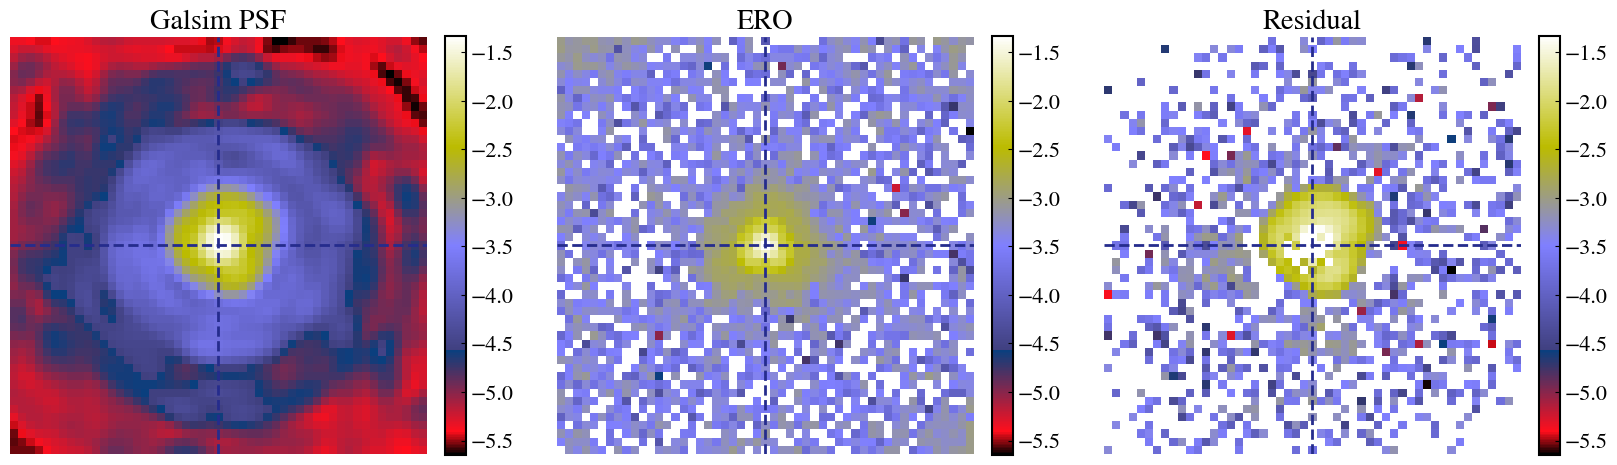

In [11]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 8))
im0 = axs[0].imshow(np.log10(euclidlike_psf_image.array), origin='lower', aspect='equal', cmap='gist_stern')
axs[0].set_title('Galsim PSF')
axs[0].axis('off');
axs[0].axhline(25, ls='--')
axs[0].axvline(25, ls='--')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(np.log10(ero_star_mean), origin='lower', aspect='equal', cmap='gist_stern')
axs[1].set_title('ERO')
axs[1].axis('off');
axs[1].axhline(25, ls='--')
axs[1].axvline(25, ls='--')
plt.colorbar(im0, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(np.log10(euclidlike_psf_image.array - ero_star_mean), origin='lower', aspect='equal', cmap='gist_stern')
axs[2].set_title('Residual')
axs[2].axis('off');
axs[2].axhline(25, ls='--')
axs[2].axvline(25, ls='--')
plt.colorbar(im0, ax=axs[2], fraction=0.046, pad=0.04)

Text(0.5, 1.0, 'mean axis=1')

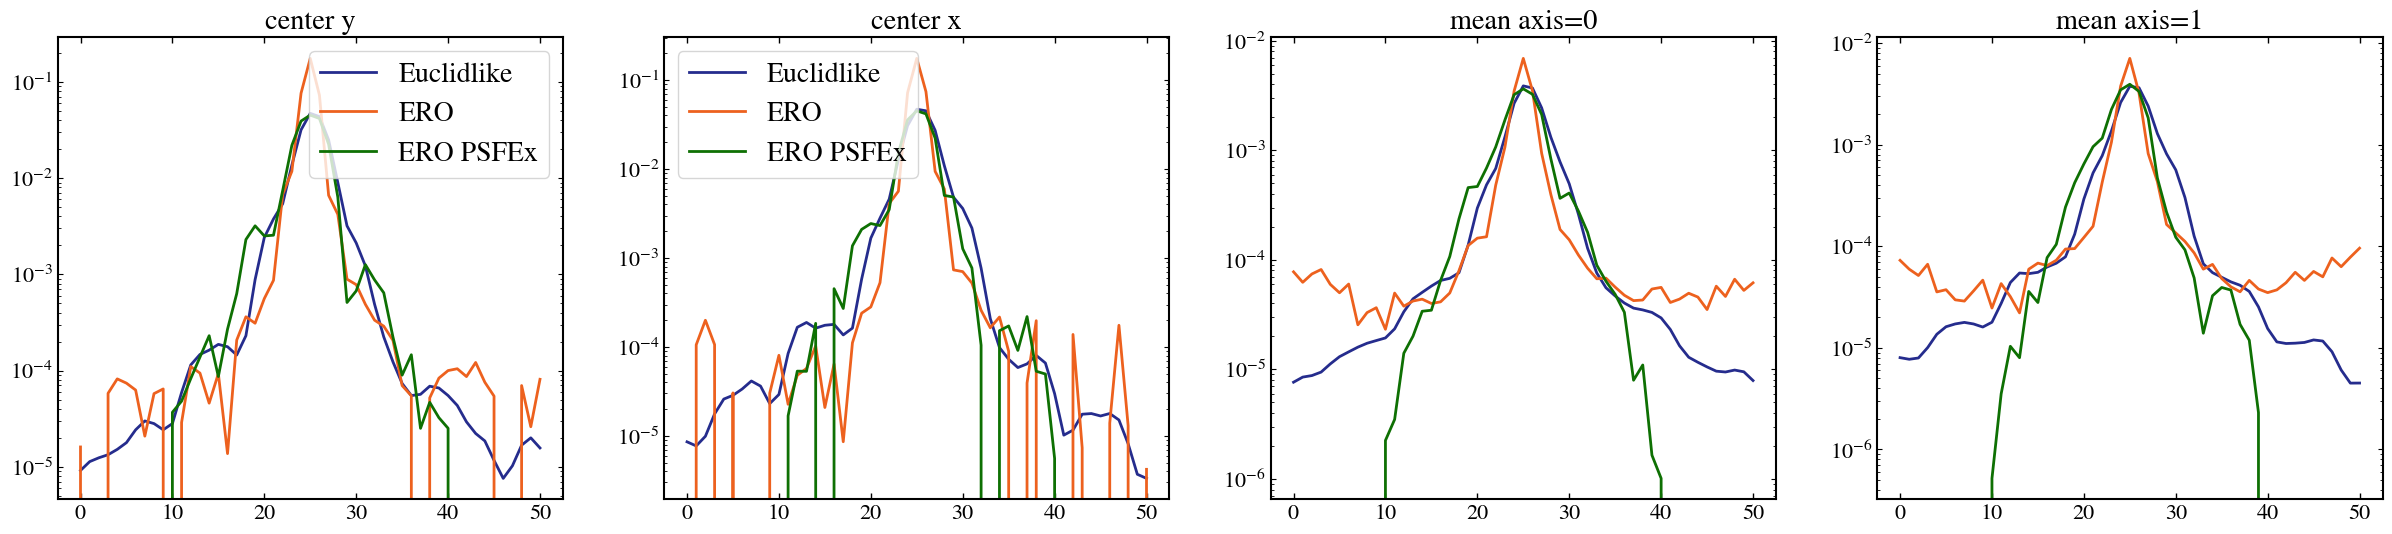

In [12]:
cx, cy = euclidlike_psf_image.array.shape
cx = int(cx / 2)
cy = int(cy / 2)

fig, axs = plt.subplots(ncols=4, figsize=(30, 6))

axs[0].plot(euclidlike_psf_image.array[cy, :], label='Euclidlike')
axs[0].plot(ero_star_mean[cy, :], label='ERO')
axs[0].plot(ero_psf_image.array[cy, :], label='ERO PSFEx')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('center y')

axs[1].plot(euclidlike_psf_image.array[:, cx], label='Euclidlike')
axs[1].plot(ero_star_mean[:, cx], label='ERO')
axs[1].plot(ero_psf_image.array[:, cx], label='ERO PSFEx')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_title('center x')

axs[2].plot(np.mean(euclidlike_psf_image.array, axis=0))
axs[2].plot(np.mean(ero_star_mean, axis=0))
axs[2].plot(np.mean(ero_psf_image.array, axis=0))
axs[2].set_yscale('log')
axs[2].set_title('mean axis=0')

axs[3].plot(np.mean(euclidlike_psf_image.array, axis=1))
axs[3].plot(np.mean(ero_star_mean, axis=1))
axs[3].plot(np.mean(ero_psf_image.array, axis=1))
axs[3].set_yscale('log')
axs[3].set_title('mean axis=1')

# Compare 2nd moment based size and shape

In [13]:
euclidlike_moments = galsim.hsm.FindAdaptiveMom(euclidlike_psf_image, use_sky_coords=True)
ero_psfex_moments = galsim.hsm.FindAdaptiveMom(ero_psf_image, use_sky_coords=True)
ero_star_moments = galsim.hsm.FindAdaptiveMom(
    galsim.ImageF(ero_star_mean, scale=euclidlike.pixel_scale), use_sky_coords=True, round_moments=True
)

factor = 2.0 * np.sqrt(2.0 * np.log(2))

print(f"Size of Euclidlike PSF: {euclidlike_moments.moments_sigma * factor:.4f} arcsec")
print(f"Size of stars from ERO: {ero_star_moments.moments_sigma * factor:.4f} arcsec")
print(f"Size of ERO PSFEx: {ero_psfex_moments.moments_sigma * factor:.4f} arcsec")

Size of Euclidlike PSF: 0.1683 arcsec
Size of stars from ERO: 0.1679 arcsec
Size of ERO PSFEx: 0.1672 arcsec
